In [1]:
import SimInterface as SI
import numpy as np
import numpy.random as rnd
import pandas as pd
import inspect
import matplotlib.pyplot as plt
import graphviz as gv
%matplotlib inline

Time = np.linspace(0,100,1001)

X = SI.Signal(label='x',data=rnd.randn(3,4),shape=4)
X_dot = SI.Signal(label='x_dot',shape=4)
W = SI.Signal(label='w',data=rnd.randn(5,3),shape=3)
V = SI.Signal(label='v',data=rnd.randn(8,5),shape=5)

Y = SI.Signal(label='y',data=rnd.randn(1,2),shape=2)
Z = SI.Signal(label='z',shape=3)

def sfun(x,w):
    return np.zeros(4)

def ofun(x,w):
    return np.zeros(2),np.zeros(3)

StateFunc = SI.Function(func=sfun,InputVars=(X,W),OutputVars=X_dot,label='sfun')
OutputFunc = SI.Function(func=ofun,InputVars=(X,W),OutputVars=(Y,Z),label='ofun')
Sys = SI.System(label='Sys')
Sys.graph

set([])


TypeError: reduce() of empty sequence with no initial value

set([<SimInterface.Function.Function instance at 0x107779248>, <SimInterface.Function.Function instance at 0x107761e60>])


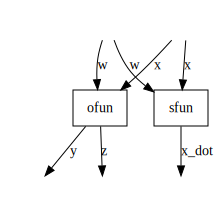

In [7]:
Sys.add(OutputFunc)
Sys.graph

In [3]:
[v.label for v in StateFunc.Vars]

['w', 'x_dot', 'x']

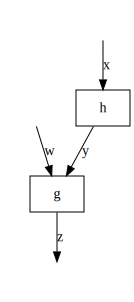

In [5]:



Mx2y = rnd.randn(2,4)
def funcx2y(x):
    return np.dot(Mx2y,x) 
    
Mwy2z = rnd.randn(3,5)
def funcwy2z(w,y):
    iv = np.hstack((w,y))
    return np.dot(Mwy2z,iv)
    
H = SI.Function(func=funcx2y,label='h',InputVars=X,OutputVars=Y)
G = SI.Function(func=funcwy2z,label='g',InputVars=(W,Y),OutputVars=Z)

N = SI.Network(Blocks=(H,G),label='Network')
N.apply()
N.graph

In [37]:
A = np.array([[0,1,0],
              [0,0,1],
              [0,0,0]])
B = np.array([[0],
              [0],
              [1]])
C = np.array([[1,0,0]])

Cont = np.hstack([B,np.dot(A,B),np.dot(A,np.dot(A,B))])
Obs = np.vstack([C,np.dot(C,A),np.dot(np.dot(C,A),A)])
print np.dot(Obs,Cont)

[[0 0 1]
 [0 1 0]
 [1 0 0]]


In [ ]:
N.InputData

In [ ]:
N.OutputData

In [ ]:
N.InternalData